In [1]:
%pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


# Imports 

In [2]:
# core libraries
import pandas as pd 
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# preprocessing
from sklearn.model_selection import train_test_split

# metrics 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch.nn.functional as F

# misc
import warnings

# Data Preprocessing

In [3]:
file = "datasets/meta_model_input.csv"
df = pd.read_csv(file)

# Visualize dataset
---
- visualizes sample of first 100 predictions and true angles

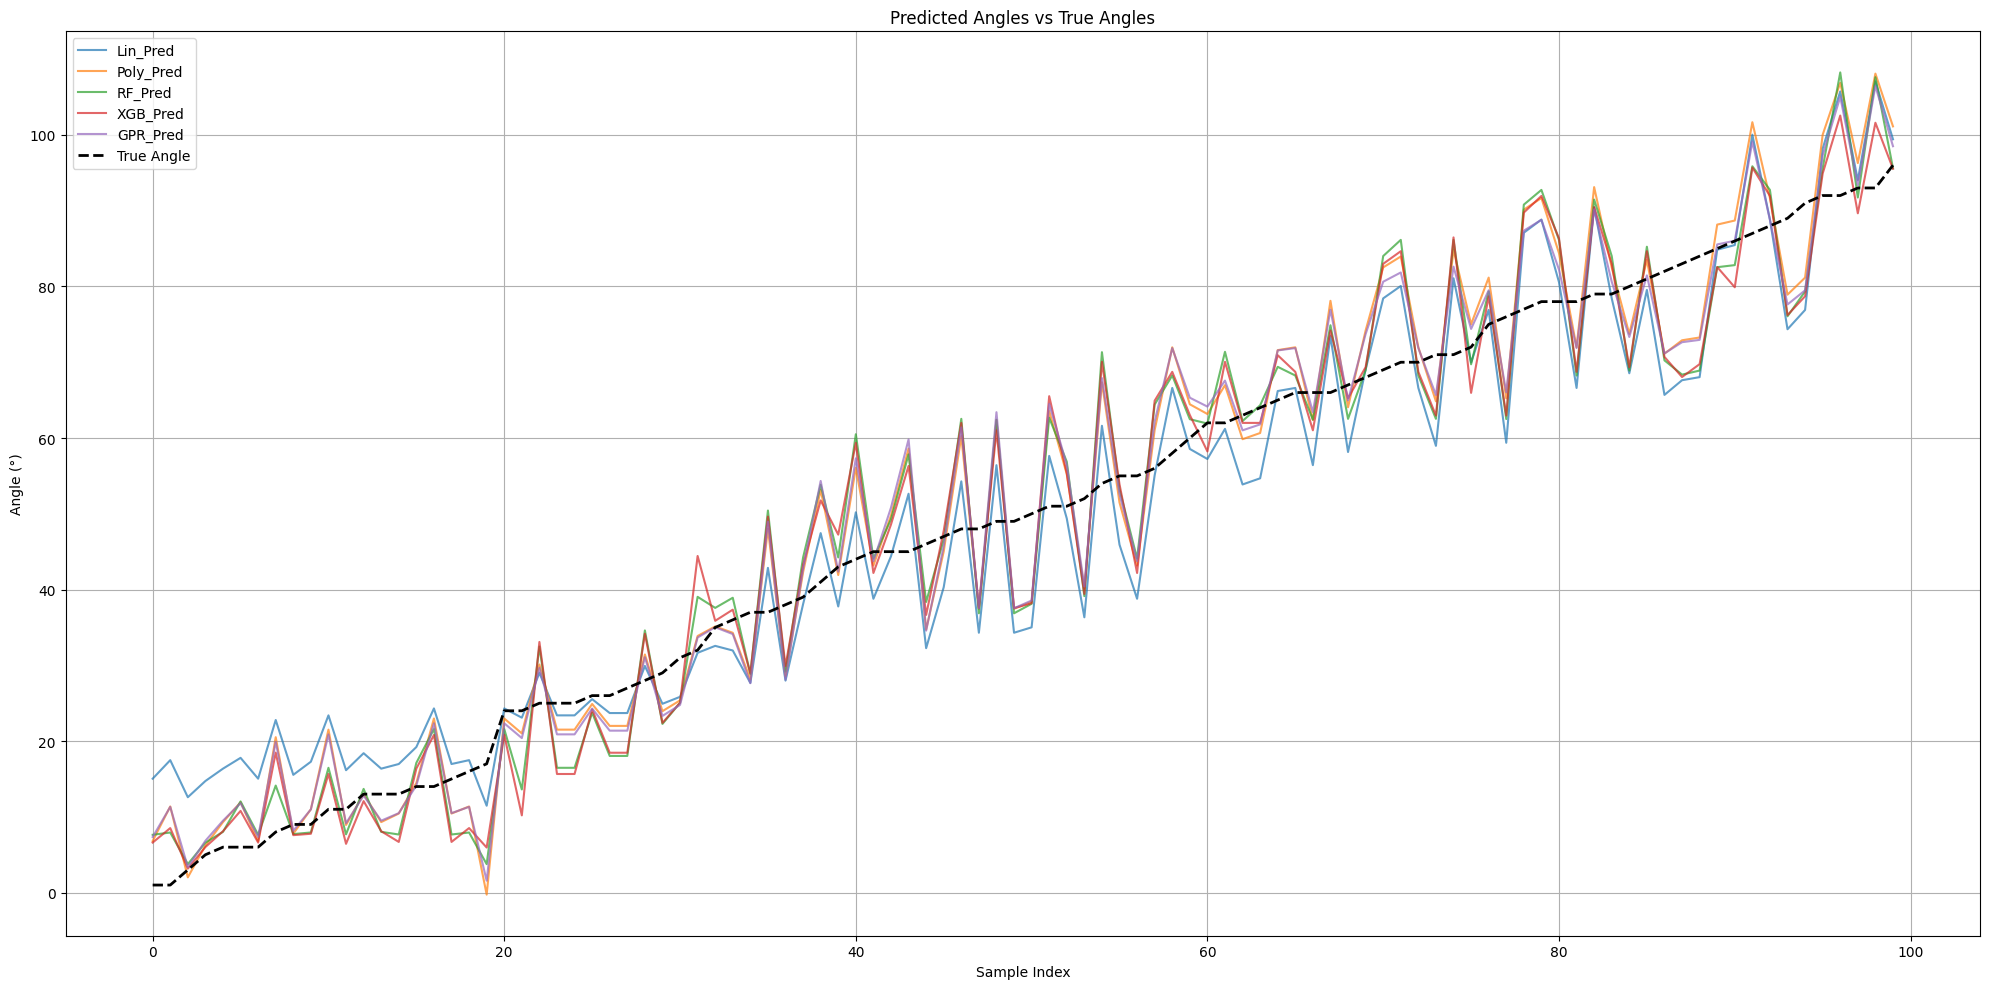

In [4]:
sample_df = df.iloc[:100]  # first 100 rows
plt.figure(figsize=(20, 10))

# Plot each prediction column
for col in sample_df.columns:
    if col.endswith("Pred"):
        plt.plot(sample_df.index, sample_df[col], label=col, alpha=0.7)

# Plot the true angles
plt.plot(sample_df.index, sample_df["True_Angle"], label="True Angle", color="black", linewidth=2, linestyle='--')
plt.xlabel("Sample Index")
plt.ylabel("Angle (°)")
plt.title("Predicted Angles vs True Angles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

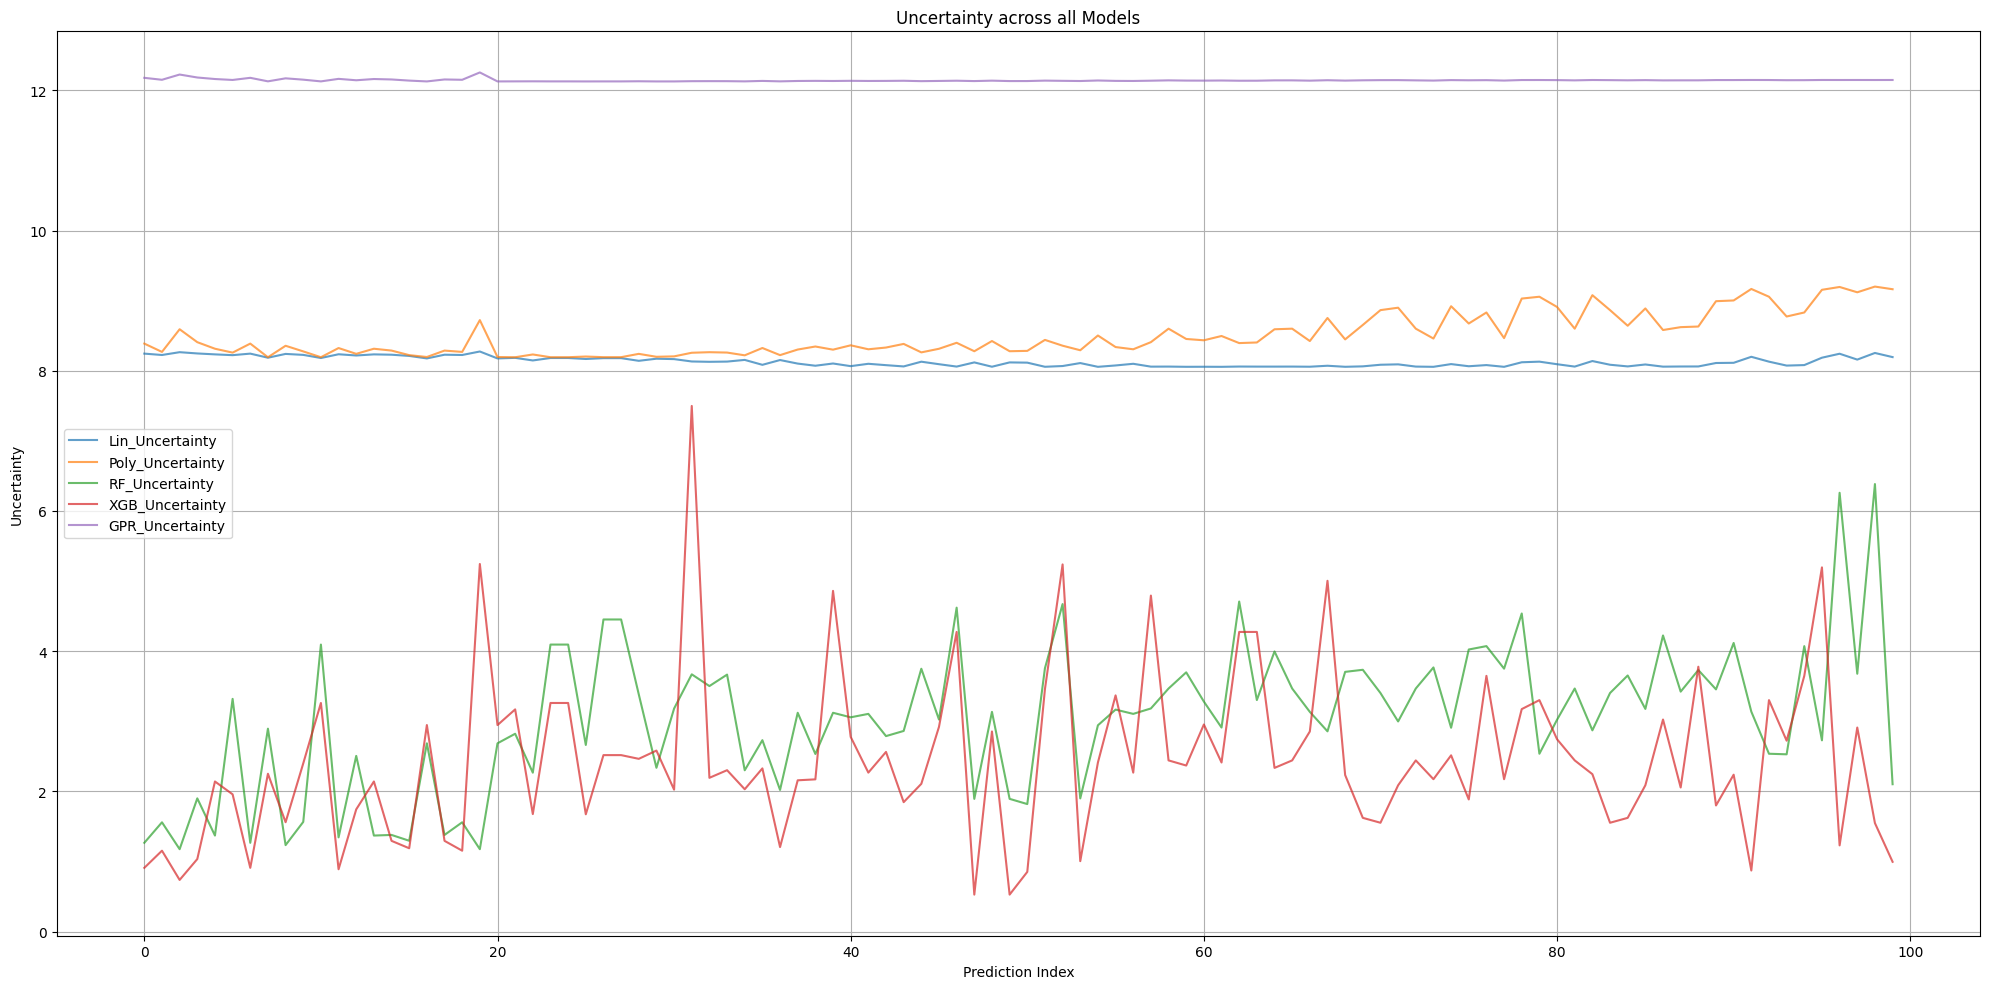

In [5]:
sample_df = df.iloc[:100]  # first 100 rows
plt.figure(figsize=(20, 10))

# Plot each prediction column
for col in sample_df.columns:
    if col.endswith("Uncertainty"):
        plt.plot(sample_df.index, sample_df[col], label=col, alpha=0.7)

# Plot the uncertainty values
plt.xlabel("Prediction Index")
plt.ylabel("Uncertainty")
plt.title("Uncertainty across all Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Min-Max Normalize Uncertainty Values (roughly between 0-1)

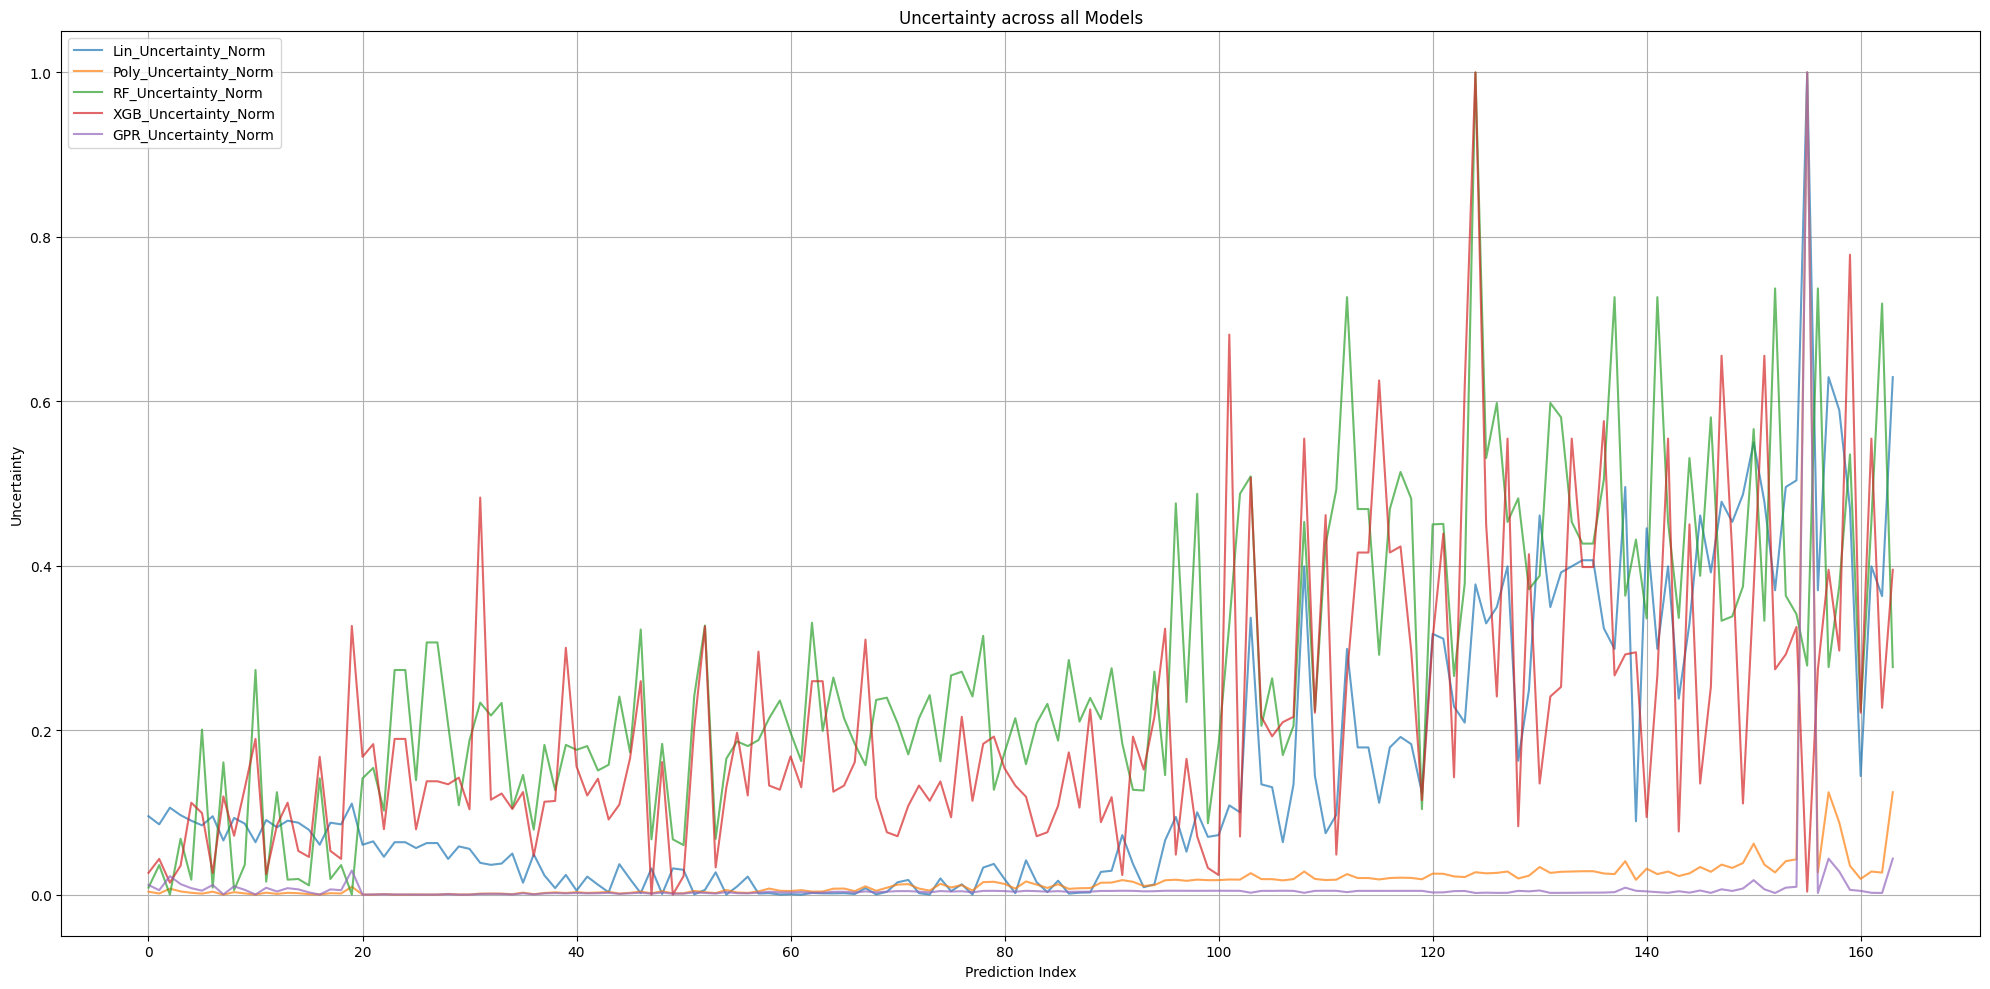

In [6]:
plt.figure(figsize=(20, 10))

# Add column of normalized uncertainity values
for col in df.columns:
    if col.endswith('Uncertainty'):
        df[f'{col}_Norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

for col in df.columns:
    if col.endswith('_Norm'):
         plt.plot(df.index, df[col], label=col, alpha=0.7)

# Plot the true angles
plt.xlabel("Prediction Index")
plt.ylabel("Uncertainty")
plt.title("Uncertainty across all Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensemble Class

In [7]:

def fuse_predictions(df: pd.DataFrame, verbose: bool = True):

    # Identify valid models with non-constant uncertainty
    models = [col.split("_")[0] for col in df.columns if col.endswith("_Uncertainty")]
    valid_models = []
    for m in models:
        unc_col = f"{m}_Uncertainty"
        if df[unc_col].max() != df[unc_col].min():
            valid_models.append(m)

    if verbose:
        print("Valid models for fusion:", valid_models)

    if len(valid_models) < 2:
        raise ValueError("Too few valid models with usable uncertainty for fusion.")

    # Prepare prediction and uncertainty matrices
    pred_cols = [f"{m}_Pred" for m in valid_models]
    unc_cols  = [f"{m}_Uncertainty" for m in valid_models]

    preds = df[pred_cols].astype(float)
    uncs  = df[unc_cols].astype(float)

    # Min-max normalisation of uncertainty (safe)
    unc_range = (uncs.max() - uncs.min()).replace(0, 1e-12)
    norm_unc = (uncs - uncs.min()) / unc_range

    # Convert to weights:  weight = 1 – norm_unc
    weights = 1.0 - norm_unc
    weights = weights.where(np.isfinite(weights), 0.0)

    row_sums = weights.sum(axis=1).replace(0, np.nan)
    
    weights = weights.div(row_sums, axis=0)
    weights.columns = preds.columns
    weights = weights.loc[preds.index]  # aligns row-wise

    # Fusion prediction
    df["Fusion_Pred"] = (preds * weights).sum(axis=1)

    # Drop any rows with NaN in fused result or truth
    df_clean = df.dropna(subset=["Fusion_Pred", "True_Angle"] + pred_cols)

    # Metric report
    def metrics(y_true, y_pred):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            r2   = r2_score(y_true, y_pred)
            n = len(y_true) # num of observations
            p = len(valid_models) # num of valid predictors/models
            adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        return f"MAE {mae:.2f}°, MSE {mse:.2f}°, RMSE {rmse:.2f}°, R² = {r2:.4f}, Adj. R² = {adjusted_r2:.4f}"

    if verbose:
        print("\nModel Performance:")
        for m in valid_models:
            print(f"{m:5s} → {metrics(df_clean['True_Angle'], df_clean[f'{m}_Pred'])}")
        print(f"{'Fusion':5s} → {metrics(df_clean['True_Angle'], df_clean['Fusion_Pred'])}")
        
    model_names = [col.replace('_Pred', '') for col in weights.columns]

    # Plot per-sample model weights
    plt.figure(figsize=(14, 6))
    sns.heatmap(weights.T, cmap="viridis", cbar_kws={'label': 'Model Weight'}, xticklabels=50)
    plt.title("Per-Sample Model Weights Heatmap")
    plt.xlabel("Sample Index")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

    return df_clean

Valid models for fusion: ['Lin', 'Poly', 'RF', 'XGB', 'GPR']

Model Performance:
Lin   → MAE 9.73°, MSE 182.76°, RMSE 13.52°, R² = 0.9304, Adj. R² = 0.9282
Poly  → MAE 9.53°, MSE 168.24°, RMSE 12.97°, R² = 0.9360, Adj. R² = 0.9339
RF    → MAE 10.46°, MSE 195.79°, RMSE 13.99°, R² = 0.9255, Adj. R² = 0.9231
XGB   → MAE 10.40°, MSE 194.92°, RMSE 13.96°, R² = 0.9258, Adj. R² = 0.9234
GPR   → MAE 9.39°, MSE 167.53°, RMSE 12.94°, R² = 0.9362, Adj. R² = 0.9342
Fusion → MAE 9.47°, MSE 168.51°, RMSE 12.98°, R² = 0.9358, Adj. R² = 0.9338


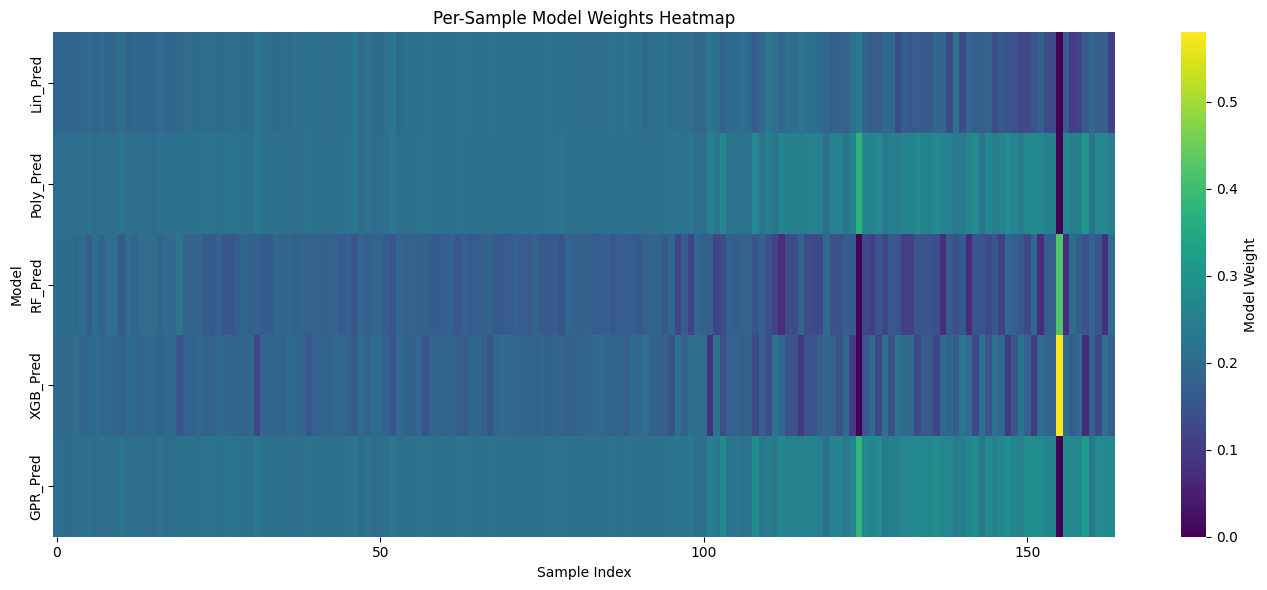

In [8]:
df_fused = fuse_predictions(df)

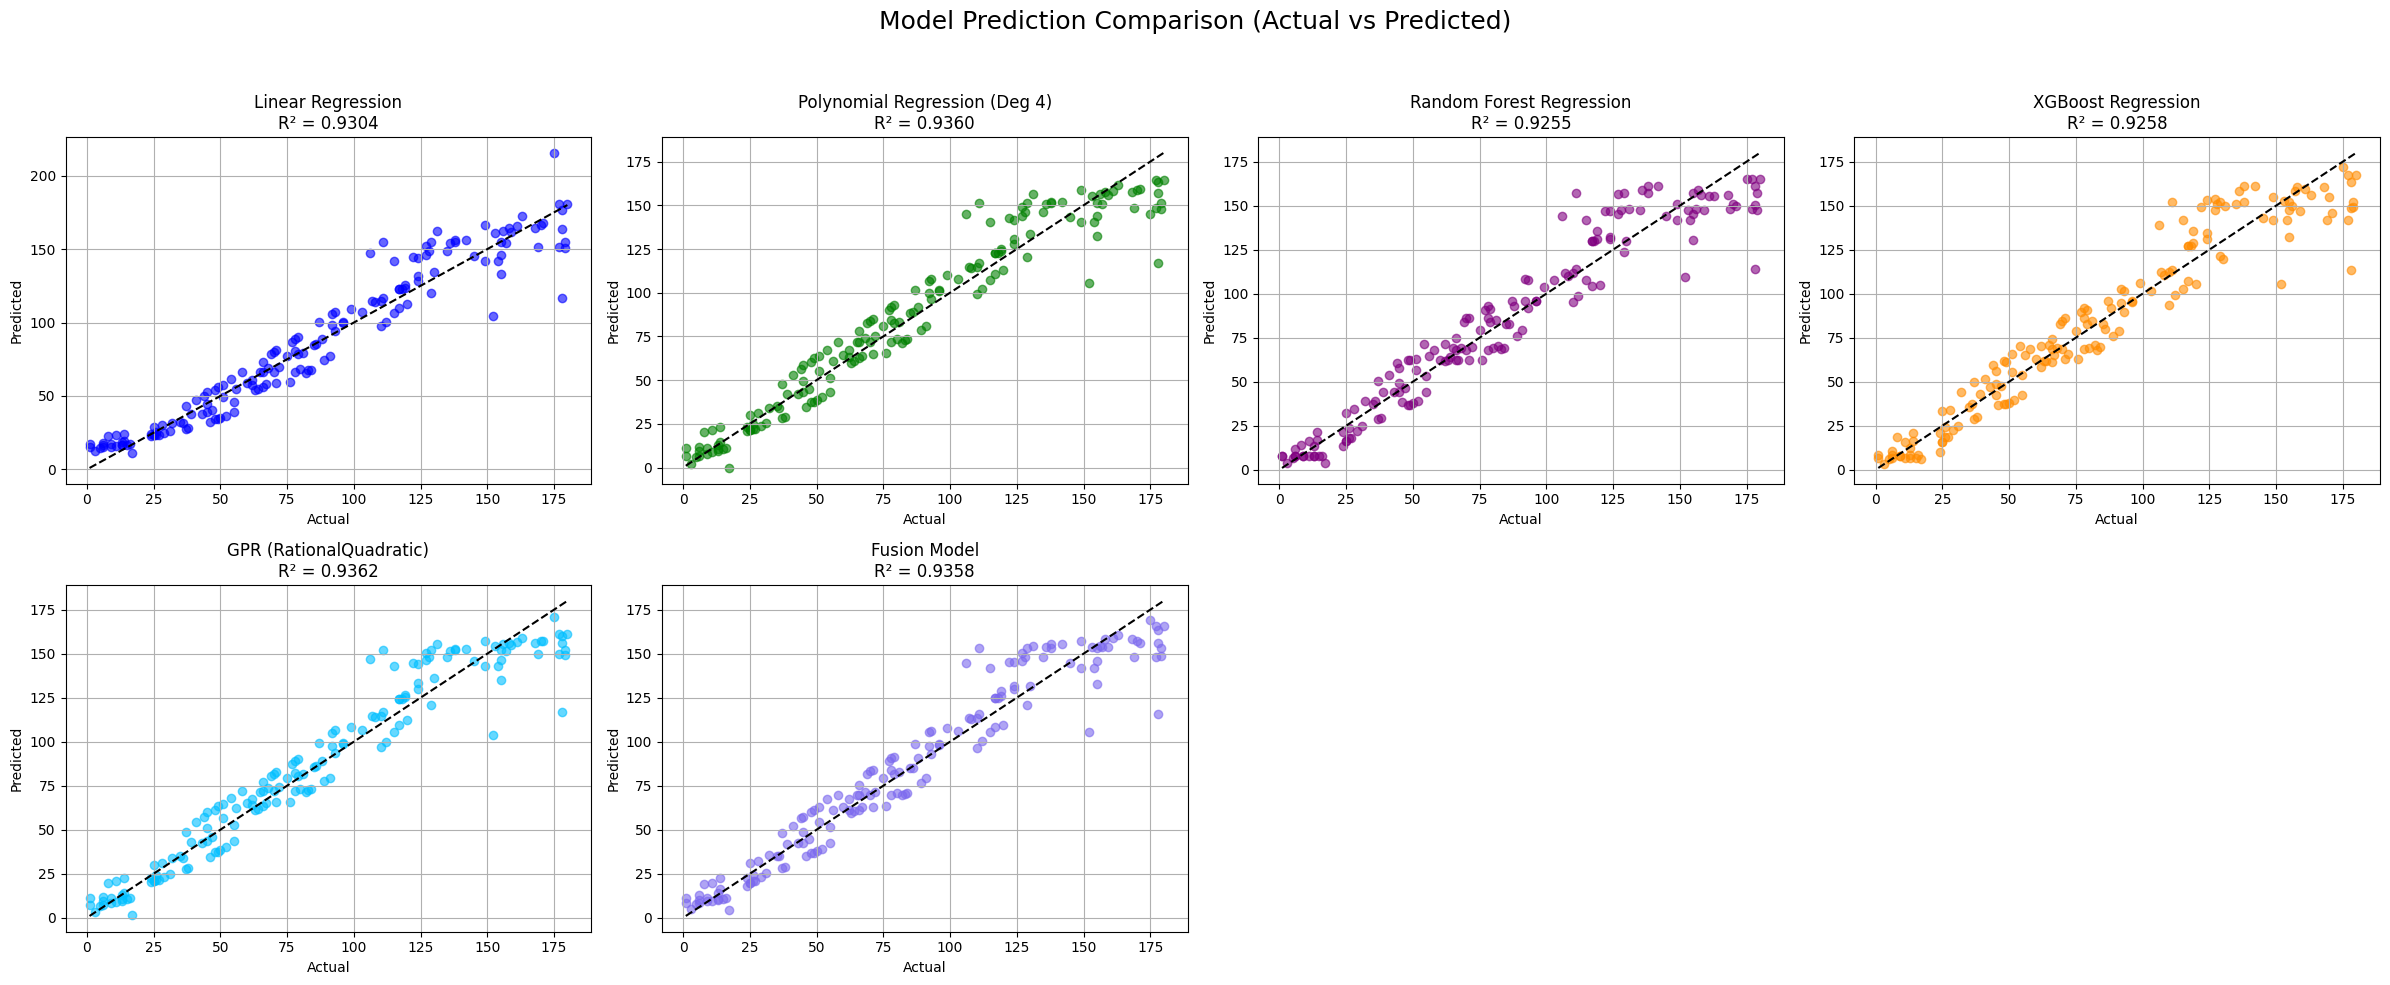

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define models and titles
models = ['Lin_Pred', 'Poly_Pred', 'RF_Pred', 'XGB_Pred', 'GPR_Pred', 'Fusion_Pred']
titles = [
    'Linear Regression',
    'Polynomial Regression (Deg 4)',
    'Random Forest Regression',
    'XGBoost Regression',
    'GPR (RationalQuadratic)',
    'Fusion Model'
]
colors = ['blue', 'green', 'purple', 'darkorange', 'deepskyblue', 'mediumslateblue']

y_true = df_fused['True_Angle']

# Set up figure and layout
plt.figure(figsize=(24, 10))

for i, (model, title, color) in enumerate(zip(models, titles, colors), start=1):
    y_pred = df_fused[model]
    
    plt.subplot(2, 4, i)
    plt.scatter(y_true, y_pred, color=color, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    r2 = r2_score(y_true, y_pred)
    plt.title(f'{title}\nR² = {r2:.4f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)

# Fill the last subplot if unused
if len(models) < 8:
    for j in range(len(models) + 1, 9):
        plt.subplot(2, 4, j)
        plt.axis('off')

plt.suptitle('Model Prediction Comparison (Actual vs Predicted)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
